# Classifying ImageNet with Binary Weights, 2-bit Activations

Have you heard of the [ImageNet](http://www.image-net.org/) database? It contains hundreds of thousands of labeled images in different categories. The 2012 variant of the ImageNet challenge, which involves using machine learning to predict which of the 1000 categories the image belongs to, was won by a deep convolutional neural network called AlexNet. This network achieved 10.8 percentage points better accuracy than the closest competitor, and in many ways started the still-ongoing surge of interest in deep neural networks.

To put things into perspective, let's load the ImageNet-1K class list and have a look at a few of them:

In [9]:
from imagenet_data.classes import *
len(imagenet_classes)
for i in range(10):
    print(imagenet_classes[i])

tench, Tinca tinca
goldfish, Carassius auratus
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
tiger shark, Galeocerdo cuvieri
hammerhead, hammerhead shark
electric ray, crampfish, numbfish, torpedo
stingray
cock
hen
ostrich, Struthio camelus


So not only the network has to distinguish between sharks and birds and the like, it also has to distinguish between *types* of these animals, which can be quite challenging for even the average human!

Today, ImageNet-1K is considered to be a "solved" challenge by some, since the prediction error rate has gone as low as 3%. But those are quite advanced architectures, and for the purposes of this tutorial we'll stick to something simpler. We will use a quantized version of the AlexNet architecture, which was proposed by Cai et al in [this paper](https://arxiv.org/abs/1702.00953) and converted to a simplified form by Umuroglu and Jahre in [this paper](https://arxiv.org/abs/1709.04060). 

## Getting the weights

Although it consists 99\% of components we have already seen, AlexNet is a *much* larger network, so its weights are not stored in this repository. We'll download them instead:

In [1]:
from QNN.layers import *
import pickle

!wget -nc http://www.idi.ntnu.no/~yamanu/alexnet-hwgq.pickle
qnn = pickle.load(open("alexnet-hwgq.pickle", "rb"))

qnn

--2017-09-28 12:57:51--  http://www.idi.ntnu.no/~yamanu/alexnet-hwgq.pickle
Resolving www.idi.ntnu.no (www.idi.ntnu.no)... 129.241.107.172
Connecting to www.idi.ntnu.no (www.idi.ntnu.no)|129.241.107.172|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248581737 (237M)
Saving to: ‘alexnet-hwgq.pickle’

alexnet-hwgq.pickle 100%[===================>] 237,07M  11,2MB/s    in 21s     

2017-09-28 12:58:12 (11,2 MB/s) - ‘alexnet-hwgq.pickle’ saved [248581737/248581737]



As you can see, the network is mainly made of convolution, fully connected, pooling and thresholding layers that we've seen before. The matrices in matrix layers (convolution and fully connected) are bigger than what we have seen before, and there are more of them, but that's about it. 

In fact, the only new thing in this network is that the first and last layers use 8-bit activations and 8-bit weights. The 8-bit activations in the first layer come from the color images themselves, and the 8-bit activation for the last layer's input is generated by using the ReLU activation function instead of thresholding. The ReLU activation function sets everything less than zero to zero like this:

![ReLU](https://i.stack.imgur.com/8CGlM.png)

Even though its positive output isn't normally limited to 8-bit numbers, you can safely clip the output to 8-bits and the network should work [just fine](https://petewarden.com/2015/05/23/why-are-eight-bits-enough-for-deep-neural-networks/).

As usual, the weights themselves are generated by training, so we won't dwell much on that except to remind that the last and first layers have 8-bit precision. We can get an overview of the weights by looking at each matrix layer like this:

In [15]:
for i in range(len(qnn)):
    L = qnn[i]
    cname = L.__class__.__name__
    if cname == "QNNConvolutionLayer" or cname == "QNNFullyConnectedLayer":
        print("Weight range for layer %d: min %d max %d" % (i, np.min(L.W), np.max(L.W)))
                

Weight range for layer 0: min -127 max 127
Weight range for layer 3: min -1 max 1
Weight range for layer 6: min -1 max 1
Weight range for layer 8: min -1 max 1
Weight range for layer 10: min -1 max 1
Weight range for layer 13: min -1 max 1
Weight range for layer 15: min -1 max 1
Weight range for layer 18: min -96 max 127


## Putting in images -- some assembly required

Let's try predicting some images with this network. This will be slightly more involved than what we needed to do before, since some additional tricks are used to train on challenging datasets like ImageNet. However, it won't be more than a few lines of Python code.

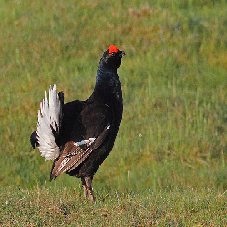

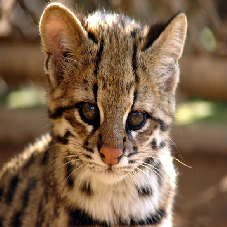

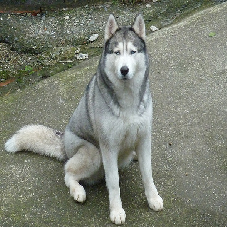

In [23]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

# define a small utility function to first display, then prepare the
# images for classification
def prepare_imagenet(img):
    # make sure the image is the size expected by the network
    img = img.resize((227, 227))
    display(img)
    # convert to numpy array
    img = np.asarray(img).copy().astype(np.int32)
    # we need the data layout to be (channels, rows, columns)
    # but it comes in (rows, columns, channels) format, so we
    # need to transpose the axes:
    img = img.transpose((2, 0, 1))
        
    # our network is trained with BGR instead of RGB images,
    # so we need to invert the order of channels in the channel axis:
    img = img[::-1, :, :]
    # finally, we need to subtract the mean per-channel pixel intensity
    # since this is how this network has been trained
    img[0] = img[0] - 104
    img[1] = img[1] - 117
    img[2] = img[2] - 123
    return img

# load test images and prepare them
img_grouse = prepare_imagenet(Image.open("imagenet_data/grouse.jpg"))
img_cat = prepare_imagenet(Image.open("imagenet_data/cat.jpg"))
img_husky = prepare_imagenet(Image.open("imagenet_data/husky.jpg"))

If you compare this to the code we used to prepare GTSRB images, you will notice three differences:

1. The input image is resized to 227x227 instead of 32x32. Networks trained on ImageNet are provided with much larger images, so that they have more information to work with.

2. The input image is provided as an array of 32-bit integers. This is because numpy will use its type to infer the type of result of matrix multiplications. Even though we are multiplying 1-bit, 2-bit and 8-bit matrices, the result matrix can require more bits per element to store numbers, e.g. the result of a 4-element 1-bit dot product can be -1x1+1x1+1x1+(-1x-1)=2

3. We subtract some values from each pixel. The values we are subtracting are the [mean of the training set](https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c), to "center" the input data around zero.

## Getting the predictions

Now that we have our input data prepared, we can define a helper function to print the winning class and give it a go. One measure of success that is used with ImageNet and other complex datasets is the so-called **top-5 score**. This means that instead of just looking for the single largest-valued output, we can look at the top-5 classifications and consider it a success if the right answer is among them, like this:

In [26]:
def imagenet_predict(img):
    # get the predictions array
    res = predict(qnn, img)
    # return the index of the largest prediction, then use the
    # classes array to map to a human-readable string
    winner_inds_top5 = np.argsort(res)[-5:]
    winner_ind = winner_inds_top5[-1]
    winner_class = imagenet_classes[winner_ind]
    # the sum of the output values add up to 1 due to softmax,
    # so we can interpret them as probabilities
    winner_prob = 100 * res[winner_ind]
    print("The QNN predicts this is a(n) %s (class %d) with %f percent probability" % (winner_class, winner_ind, winner_prob))
    print("Top-5 classes:")
    for i in winner_inds_top5:
        print(imagenet_classes[i])
    print("")

imagenet_predict(img_grouse)
imagenet_predict(img_cat)
imagenet_predict(img_husky)

The QNN predicts this is a(n) black grouse (class 80) with 98.129130 percent probability
Top-5 classes:
prairie chicken, prairie grouse, prairie fowl
hen
cock
vulture
black grouse

The QNN predicts this is a(n) Egyptian cat (class 285) with 30.018796 percent probability
Top-5 classes:
leopard, Panthera pardus
tiger cat
lynx, catamount
cheetah, chetah, Acinonyx jubatus
Egyptian cat

The QNN predicts this is a(n) Eskimo dog, husky (class 248) with 59.245122 percent probability
Top-5 classes:
white wolf, Arctic wolf, Canis lupus tundrarum
Norwegian elkhound, elkhound
Siberian husky
malamute, malemute, Alaskan malamute
Eskimo dog, husky



And success! Even the top-1 classifications were all correct in this case, notice how the top-5 classes include other visually similar categories.